In [550]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import multiprocessing

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
sys.path.append(".")
from src.dc_smc import dc_smc 
from src.model import Model, LinearGaussian, NonLinearGaussian
from src.utils import resample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Linear Gaussian HMM

In [551]:
# generate data
nsamples = 50 # n_y
T = 10
tf.random.set_seed(0)

# sigma0 = np.array([[1.]])
sigma0 = np.array(1.)
A = np.array([[0.8]])
B = np.ones((1, 1))
C = np.ones((1, 1))
D = np.ones((1, 1))

linear_hmm = LinearGaussian(sigma0, A, B, C, D)
x_vec, y_vec = linear_hmm.sample(nsamples, T)

In [552]:
# SIS
nx = 1000

x_pos = np.zeros((T+1, nx))
log_w = np.zeros_like(x_pos)
x_pos_resampled = np.zeros_like(x_pos)

# t=0
proposal_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1))
x_pos[0, :] = proposal_init.sample(nx)[:, 0]
log_w[0, :] = linear_hmm.log_gamma(x_pos[:1, :], None) - proposal_init.log_prob(x_pos[0, :])
x_pos_resampled[0, :] = resample(log_w[0, :], x_pos[0, :])

# t>=1
for t in range(T):
    # proposal: N(x_{t-1}, 1)
    proposal_t = tfd.Normal(loc=x_pos[t, :], scale=np.ones(1))
    x_pos[t+1, :] = proposal_t.sample(1)
    
    alpha_t = linear_hmm.log_gamma(x_pos[:(t+2), :], y_vec[:(t+1), :]) - \
        linear_hmm.log_gamma(x_pos[:(t+1), :], y_vec[:t, :]) - \
        proposal_t.log_prob(x_pos[t+1, :])
    log_w[t+1, :] = log_w[t, :] + alpha_t
    
    x_pos_resampled[t+1, :] = resample(log_w[t+1, :], x_pos[t+1, :])

    print("true x{}: {} estimate: {}".format(
        t+1, 
        x_vec[t+1, 0], 
        tf.reduce_mean(x_pos_resampled[t+1, :]).numpy()
    ))
    

true x1: 2.2232272715607047 estimate: 2.0194198238800296
true x2: 3.477558810809355 estimate: 3.394570652959467
true x3: 1.6074973498178333 estimate: 1.8315214954282502
true x4: 0.7157036784802129 estimate: 0.31924416522331583
true x5: 1.921818385403494 estimate: 1.331434560057252
true x6: 0.044118388399394526 estimate: 0.5539142400081464
true x7: 0.678292810046603 estimate: 0.6610092158361197
true x8: -0.6627111441898904 estimate: -0.59694124551972
true x9: -2.064314985832259 estimate: -2.722512701259994
true x10: -2.7020150856659293 estimate: -3.371547923705364


true x1: 2.2232272715607047 estimate: 2.0194198238800296


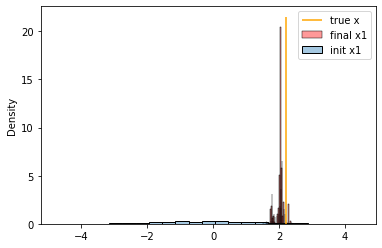

In [553]:
ind = 1

x_true = x_vec[ind, 0]

sns.histplot(x_pos_resampled[ind, :], stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(x_pos[ind, :], stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true, 0, ymax, color="orange", label="true x")
plt.legend()

print(
    f"true x{ind}:", x_true,
    "estimate:", tf.reduce_mean(x_pos_resampled[ind, :]).numpy()
)

# Non-linear Gaussian HMM

In [554]:
# generate data
tf.random.set_seed(0)
nsample = 50
T = 4

sigma0 = np.array([[1.]])
mu0 = np.zeros((1, 1))
sigma_v = np.array([[np.sqrt(10)]])
sigma_w = np.ones((1, 1))

nonlinear_hmm = NonLinearGaussian(sigma0, mu0, sigma_v, sigma_w)
x_vec, y_vec = nonlinear_hmm.sample(nsample, T)

In [555]:
# SIS
nx = 1000

x_pos = np.zeros((T+1, nx))
log_w = np.zeros_like(x_pos)
x_pos_resampled = np.zeros_like(x_pos)

# t=0
proposal_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1))
x_pos[0, :] = proposal_init.sample(nx)[:, 0]
log_w[0, :] = nonlinear_hmm.log_gamma(x_pos[:1, :], None) - proposal_init.log_prob(x_pos[0, :])
x_pos_resampled[0, :] = resample(log_w[0, :], x_pos[0, :])

# t>=1
for t in range(T):
    # proposal: N(x_{t-1}, 1)
    proposal_t = tfd.Normal(loc=x_pos[t, :], scale=np.ones(1))
    x_pos[t+1, :] = proposal_t.sample(1)
    
    alpha_t = nonlinear_hmm.log_gamma(x_pos[:(t+2), :], y_vec[:(t+1), :]) - \
        nonlinear_hmm.log_gamma(x_pos[:(t+1), :], y_vec[:t, :]) - \
        proposal_t.log_prob(x_pos[t+1, :])
    log_w[t+1, :] = log_w[t, :] + alpha_t
    
    x_pos_resampled[t+1, :] = resample(log_w[t+1, :], x_pos[t+1, :])

    print("true x{}: {} estimate: {}".format(
        t+1, 
        x_vec[t+1, 0], 
        tf.reduce_mean(x_pos_resampled[t+1, :]).numpy()
    ))
    

(1, 1000) (1000,) (1, 1) (1, 1)
true x1: 18.46339823101679 estimate: 4.291952124693818
(1, 1000) (1000,) (1, 1) (1, 1)
(1, 1000) (1000,) (1, 1) (1, 1)
true x2: 9.935913730800971 estimate: -2.2721344437953865
(1, 1000) (1000,) (1, 1) (1, 1)
(1, 1000) (1000,) (1, 1) (1, 1)
true x3: 7.2453845003430155 estimate: 6.016206116044707
(1, 1000) (1000,) (1, 1) (1, 1)
(1, 1000) (1000,) (1, 1) (1, 1)
true x4: -4.2920114514712395 estimate: 6.642293988349027


true x1: 18.46339823101679 estimate: 4.291952124693818


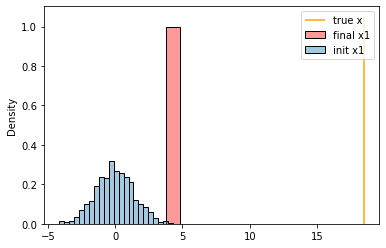

In [561]:
ind = 1

x_true = x_vec[ind, 0]

sns.histplot(x_pos_resampled[ind, :], stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(x_pos[ind, :], stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true, 0, ymax, color="orange", label="true x")
plt.legend()

print(
    f"true x{ind}:", x_true,
    "estimate:", tf.reduce_mean(x_pos_resampled[ind, :]).numpy()
)

## Compare with SMC

In [336]:
# need to change according to model!
def logprior(x):
    T = x.shape[0] - 1
    log_p = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[0, :])
#     print("here", log_p.shape, x[0, :].shape, mu0.shape, sigma0.shape)
    for i in range(1, T):
        log_p += tfd.Normal(
            loc=nonlinear_hmm._latent_mean(x[i-1, :], i), 
            scale=sigma_v
        ).log_prob(x[i, :])
        print(i, T)
    log_p = tf.reshape(log_p, (-1, 1))
    print("prior", log_p.shape)
    return log_p

def loglik(x):
    T = x.shape[0] - 1
    log_lik = 0
    for t in range(T):
        log_lik += tfd.Normal(
            loc=1/20 * x[t+1, :]**2, 
            scale=sigma_w
        ).log_prob(y_vec[t, :].reshape(-1, 1))
        print(t, T, x.shape)
    log_lik = tf.reshape(tf.reduce_sum(log_lik, axis=0), (-1, 1))
    print("finished")
    print("lik", log_lik.shape)
    return log_lik

def smc(seed, samples_init):
    return tfp.experimental.mcmc.sample_sequential_monte_carlo(
        prior_log_prob_fn=logprior,
        likelihood_log_prob_fn=loglik,
        current_state=samples_init,
        seed=seed)[1]

In [337]:
x_smc_init = tfd.Normal(loc=np.array(0.), scale=np.array(1.)).sample((T+1, nx))
x_smc_final = smc(1, x_smc_init)

0 4 (5, 1000)
1 4 (5, 1000)
2 4 (5, 1000)
3 4 (5, 1000)
finished
lik (1000, 1)
1 4
2 4
3 4
prior (1000, 1)
0 4 (5, 1000)
1 4 (5, 1000)
2 4 (5, 1000)
3 4 (5, 1000)
finished
lik (1000, 1)


InvalidArgumentError: indices[250,7] = 5 is not in [0, 5) [Op:GatherV2]

# Hierarchical model

In [537]:
def sample_y(nsamples, x_vec, eta):
    y_vec = tfd.Normal(loc=x_vec[1:, :], scale=eta).sample(nsamples)
    return y_vec

def hierarchical_targets(y, mu0, sigma0, eta, tau):
    """
        y: n_y x nchildren
        x: nsamples x dim x nchildren
    """
    def log_gamma_leaf(x):
        log_lik = tfd.Normal(loc=x[:, :, 1:], scale=eta).log_prob(y)
        log_lik = tf.reduce_sum(log_lik, axis=1, keepdims=True)
        
        x0 = x[:, :, 0][:, :, np.newaxis]
        log_p = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x0)
        log_p += tfd.Normal(loc=x0, scale=tau).log_prob(x[:, :, 1:])
        
        res = tf.reduce_sum(log_p + log_lik, axis=-1, keepdims=True)
        return res
    
    def log_gamma_root(x):
        x0 = x[:, :, 0][:, :, np.newaxis]
        log_p = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x0)
        return log_p
    
    return log_gamma_leaf, log_gamma_root
    
# def sample_x(nsamples, mu0, sigma0, tau):
#     x_vec = np.zeros((nsapmles, 5))
#     x_vec[:, 0] = tfd.Normal(loc=mu0, scale=sigma0).sample(nsamples)
#     x_vec[:, 1:] = tfd.Normal(loc=x_vec[:, 0], scale=tau).sample((nsamples, x_vec.shape[1]-1))
#     return x_vec


In [538]:
class Proposal:
    def __init__(self):
        self.dist = tfd.Normal(np.zeros(1), np.ones(1))
    def log_prob(self, mu_new, mu_curr):
        return self.dist.log_prob(mu_new) # nsample x dim
    def sample(self, size, mu_curr):
        return self.dist.sample(size)[:, :, 0]

In [543]:
# sample data
tf.random.set_seed(0)

sigma0 = np.ones((1, 1))
eta = np.ones((1, 1))
tau = np.ones((1, 1))

nchildren = 4
nsample = 100 # n_y
x_vec = np.ones((1, 1, nchildren + 1))
x_vec[:, :, 1:] = tf.reshape(
    tfd.Normal(loc=x_vec[:, :, 0], scale=np.array(1.)).sample(nchildren),
    (1, -1)
)
y_vec = tfd.Normal(loc=x_vec[:, :, 1:], scale=eta).sample(nsample)[:, 0, 0, :]
assert y_vec.shape[-1] == nchildren, f"shape of y_vec is wrong! Got {y_vec.shape}"

proposal = Proposal()
log_gamma_leaf, log_gamma_root = hierarchical_targets(y_vec, mu0, sigma0, eta, tau)

In [546]:
model = Model(log_gamma_root, proposal, 0)
for i in range(nchildren):
    model.build_child(log_gamma_leaf, proposal, i)